In [126]:
import json
import os
import csv
from datetime import datetime, timezone
import re

class EnsembleDataCollector:
    """
    A base json data collector, holding methods to be used in parsing raw instagram and tiktok JSON files
    """
    def timestamp_to_date(self, timestamp):
        """Given a Unix timestamp convert the timestamp to a readable datetime object"""
        # Convert to a datetime object
        dt_object = datetime.fromtimestamp(timestamp, timezone.utc)

        return dt_object

In [127]:
class EnsembleInstagramDataCollector(EnsembleDataCollector):
    """
    An instagram data collector, holding methods to be used in parsing raw instagram JSON files
    """
    def __init__(self, output_csv="data/instagram/instagram_data.csv"):
        """
        Initializes EnsembleInstagramDataCollector

        Parameters:
        output_csv (str) - the output csv file path
        """
        
        self.output_csv = output_csv

        self.field_names = [
            "Post ID", "Account Username", "Type of Post", "Date", "Day of Week", "Time of Day",
            "Likes", "Comments", "Caption", "Hashtags", "Tagged Users", "Is Video", "View Count (if video)"
        ] # Stores the headers of the metadata we are collecting
        
    
    def process_all_json_in_folder(self, folder_path):
        """
        Process all validated JSON files in the specified folder, extract important metadata, and save to csv

        Parameters:
        folder_path (str) - the specified folder path
        """

        # Open csv to be written to, allows us to write after collecting data from each individual JSON
        with open(self.output_csv, "w", newline="", encoding="utf-8") as output:
            writer = csv.DictWriter(output, self.field_names)
            writer.writeheader()
        
            # Loop through each file in folder
            for file in os.listdir(folder_path):
                if file.endswith(".json"): # Safety check, I don't think this is necessary but just in case
                    file_path = os.path.join(folder_path, file)
                    try:
                        # Try to open and load file JSON
                        with open(file_path, "r", encoding="utf-8") as fp:
                            
                            json_data = json.load(fp)
                        
                            if "data" in json_data and "posts" in json_data["data"]: # The JSON is valid and holds information
                                # Get the list of posts
                                posts = json_data["data"].get("posts") 
                                # Iterate through each post, gathering data and writing to output_csv as we go
                                for post in posts: 
                                    post_data = self.collect_metadata(post)
                                    writer.writerow(post_data) # write each post's parsed data to csv
                    except Exception as e:
                        print(f"Error loading JSON for {file_path}: {e}")
                        continue

    def collect_metadata(self, post):
        """
        Collects all relevant metadata stored in the post. Specifically:
        post id, username of the account that posted, type of post,
        date of post, day of week, time of day, number of likes,
        number of comments, caption text, hashtags, list of tagged users,
        (T/F) is a video, (if video) view count

        Parameters:
        post (Json object) - The JSON data of the respective post

        Returns:
        metadata - a structured row dictionary
        """
        # Convert timestamp to datetime object
        try:
            dt_object = self.timestamp_to_date(post["node"]["taken_at_timestamp"])
        except Exception as e:
            print(f"Error parsing timestamp: {e}")
            dt_object = None

        # Collect caption text
        try:
            caption_json = post["node"]["edge_media_to_caption"]
            caption_text = self.get_caption_text(caption_json)
        except Exception as e:
            print(f"Error parsing caption: {e}")
            caption_text = None

        # Boolean, true only if post is a video
        is_video = post["node"]["is_video"]
        
        try:
            metadata = {
                "Post ID": post["node"]["id"],
                "Account Username": post["node"]["owner"]["username"],
                "Type of Post": post["node"]["__typename"],
                "Date": dt_object.strftime("%Y-%m-%d") if dt_object else None,
                "Day of Week": dt_object.strftime("%A") if dt_object else None,
                "Time of Day": dt_object.strftime("%H:%M:%S") if dt_object else None,
                "Likes": post["node"]["edge_media_preview_like"].get("count", 0),
                "Comments": post["node"]["edge_media_to_comment"].get("count", 0),
                "Caption": caption_text,
                "Hashtags": self.get_hashtags_from_caption(caption_text) if caption_text else None,
                "Tagged Users": self.get_tagged_users(post["node"]["edge_media_to_tagged_user"]),
                "Is Video": is_video,
                "View Count (if video)": post["node"].get("video_view_count", "") if is_video else ""
            }
        except Exception as e:
            print(f"Error parsing metadata: {e}")

        return metadata

    def get_caption_text(self, caption_json):
        """
        Return the text within a caption, if it exists

        Parameters:
        caption_json (JSON object) - The caption's json data

        Returns:
        caption_text (str) - all of the text contained in the caption
        """
        try:
            caption_text = caption_json["edges"][0]["node"].get("text", "")
        except Exception as e:
            print(f"Error parsing caption text in {caption_json}: {e}")

        return caption_text

    def get_hashtags_from_caption(self, caption_text):
        """
        Returns a string list of hashtags within the given caption text

        Parameters:
        caption_text (str) - The caption text

        Returns:
        hashtags (str) - The string list of hashtags in the caption
        """

        hashtag_list = re.findall(r"#\w+", caption_text)

        if not hashtag_list:
            return "" # No hashtags found

        hashtags = ", ".join(hashtag_list)

        return hashtags

    def get_tagged_users(self, tagged_user_json):
        """
        Returns a string list of tagged usernames

        Parameters:
        tagged_user_json (JSON object) - The edge_media_to_tagged_user json

        Returns:
        tagged_users (str) - The string list of tagged users in the post
        """
        # Check for None, unsure if necessary
        if not tagged_user_json: 
            
            print(f"edge_media_to_tagged_user does not existl.")

        try: 
            # Make sure the list exists
            tagged_user_list = tagged_user_json["edges"]
            
            usernames = [tagged_user["node"]["user"]["username"] for tagged_user in tagged_user_list]
        except Exception as e:
            print(f"Error parsing tagged user list: {e}")

        # Turn the list into a string list, seperated by commas
        tagged_users = ", ".join(usernames)

        return tagged_users
            

In [128]:
# Code used to gather necessary instagram metadata
instagram_data_collector = EnsembleInstagramDataCollector()

instagram_data_collector.process_all_json_in_folder("data/raw_instagram")

In [129]:
# Now we find stuff out from the metadata, 
# such as our EngagementRating, ViewEngagment, AverageEngagment, etc

In [130]:
import pandas as pd # For easy data transformation and access

insta_df = pd.read_csv("data/instagram/instagram_data.csv")

In [131]:
class InstagramAnalysisTool:
    """
    A class that holds all the methods and tools used to
    gather relevant information from the collected instagram metadata.
    """
    def __init__(self, insta_df=insta_df, avg_engagement_score=None):
        self.insta_df = insta_df

        if not avg_engagement_score:
            avg_engagement_score = self.update_avg_engagement()
        else:
            self.avg_engagement_score = avg_engagement_score

    def update_avg_engagement(self):
        """
        Since we don't have access to a follower count on Instagram, let's get the
        average the number of engagements (likes + comments) for a post.
        We will utilize this average to calculate engagement scores
        """
        total_likes = self.insta_df["Likes"].sum()
        total_comments = self.insta_df["Comments"].sum()
        total_posts = len(self.insta_df)

        avg_engagement_score_raw = (total_likes + total_comments) / total_posts
        avg_engagement_score = round(avg_engagement_score_raw) # Rounding since you cannot have .1 likes/comments
        print(avg_engagement_score)

        self.avg_engagement_score = avg_engagement_score

    def generate_engagement_scores(self):
        """
        Create a new column in insta_df called 'Engagement Score',
        equal to the total likes + comments of a post / avg_engagement_score.
        Used to determine if a post is above, below, or average in terms of engagement.
        > 100 -> above average,
        == 100 -> average,
        < 100 -> below average
        """
        self.insta_df["Engagement Score"] = round(((self.insta_df["Likes"] + self.insta_df["Comments"]) / self.avg_engagement_score) * 100, 2)


    def generate_viewer_engagement_scores(self):
        """
        Create a new colun in insta_df called "Viewer Engagement Score"
        only if the given post is a video, the score is
        equal to the total likes + comments / views.
        Used to determine how well the video engaged the viewer.

        Viewer Engagement Score:
        Based on the number of views determines what % of those viewers engaged with the post
        """
        self.insta_df["Viewer Engagement Score"] = self.insta_df.apply(
            lambda row: round((row["Likes"] + row["Comments"]) / row["View Count (if video)"] * 100, 2)
            if row["Is Video"] else None,
            axis = 1)

    

In [132]:
"""
After removing duplicate posts, the number of posts went from ~15,000 -> 51. Which is slightly concerning
but post IDs are unique according to Instaloader documentation so hopefully that means posts were scrapped
MULTIPLE times repeatedly.
"""

tool = InstagramAnalysisTool()

# Remove duplicate occurences of posts from data, keeping the most up-to-date version of each post
tool.insta_df.drop_duplicates(subset="Post ID", keep="last", inplace=True)

tool.update_avg_engagement()

tool.generate_engagement_scores()
 
tool.generate_viewer_engagement_scores() # For video posts

tool.insta_df["Date"] = pd.to_datetime(tool.insta_df["Date"]) # Convert string back to datetime

tool.insta_df.sort_values(by="Date", inplace=True) # Sort by date

tool.insta_df.to_csv("data/instagram/instagram_data_1.csv", index=False)

36466
46700


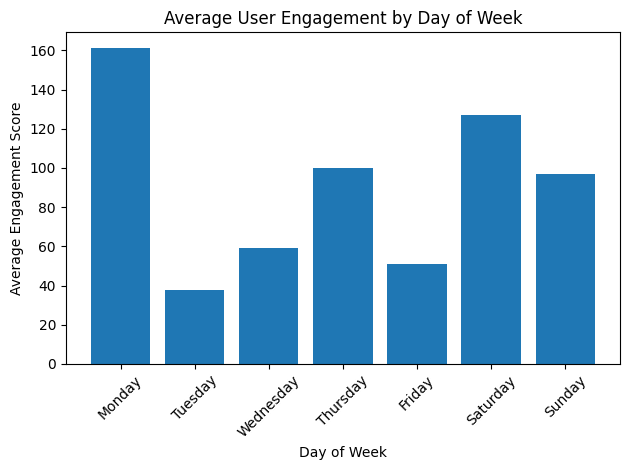

In [133]:
import matplotlib.pyplot as plt # For data visualization

"""
Grouping engagement scores by week to see if any day shows preference
"""
avg_engagement_by_day = tool.insta_df.groupby("Day of Week")["Engagement Score"].mean()

week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_engagement_by_day = avg_engagement_by_day.reindex(week)

plt.bar(avg_engagement_by_day.index, avg_engagement_by_day.values)
plt.xlabel("Day of Week")
plt.ylabel("Average Engagement Score")
plt.title("Average User Engagement by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [134]:
"""
Monday had an abnormally high average user engagement,
looking at specific monday posts to gain understanding
"""
"""
Conclusion: Correlation not causeation, 3 viral adidasfootball posts were on Monday that skewed
the results
"""

monday_rows = tool.insta_df[tool.insta_df["Day of Week"] == "Monday"].copy()
monday_rows.sort_values(by="Date", inplace=True)
monday_rows.to_csv("data/instagram/instagram_data_1_monday_rows.csv", index=False)

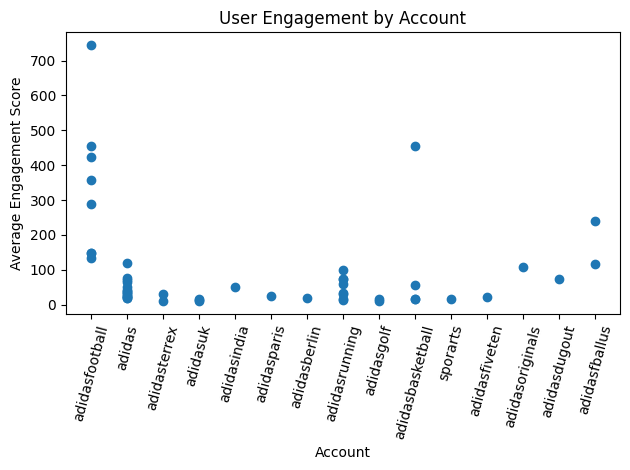

In [135]:
"""
Plotting against accounts to see what account gets the most engagement,
expecting adidasfootball/adidas
"""

"""
Conclusion: adidasfootball generates the most user engagement BY FAR, surprisingly, it looks like
the main adidas account doesn't generate that much engagement.
It could be beneficial to look at post frequency.
"""

plt.scatter(tool.insta_df["Account Username"], tool.insta_df["Engagement Score"])
plt.xlabel("Account")
plt.ylabel("Average Engagement Score")
plt.title("User Engagement by Account")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

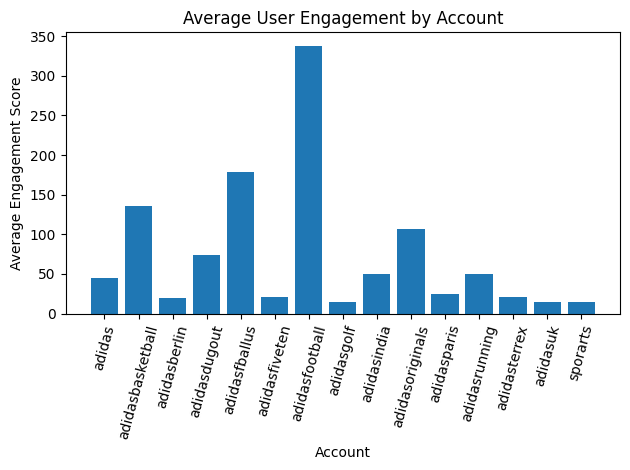

In [136]:
"""
Averaging out the user engagement by account clearly shows that football/soccer accounts
produce MUCH higher engagement than all other accounts
"""

avg_engagement_by_account = tool.insta_df.groupby("Account Username")["Engagement Score"].mean()

plt.bar(avg_engagement_by_account.index, avg_engagement_by_account.values)
plt.xlabel("Account")
plt.ylabel("Average Engagement Score")
plt.title("Average User Engagement by Account")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [137]:
"""
Looking at specifics for adidasfootball posts to hopefully find more information for analysis
"""
adidas_football_rows = tool.insta_df[tool.insta_df["Account Username"] == "adidasfootball"].copy()
adidas_football_rows.sort_values(by="Date", inplace=True)
adidas_football_rows.to_csv("data/instagram/instagram_data_1_adidasfootball.csv", index=False)

In [138]:
"""
Ordering posts by Engagement Score for analysis
"""
engagement_score = tool.insta_df.copy()
engagement_score.sort_values(by="Engagement Score", inplace=True, ascending=False)
engagement_score.to_csv("data/instagram/instagram_data_1_engagement_score.csv", index=False)

In [139]:
"""
Focusing on High Engagement Posts (Score > 100)
"""
high_engagement = engagement_score[engagement_score["Engagement Score"] > 100].copy()
high_engagement.to_csv("data/instagram/instagram_data_1_high_engagment.csv", index=False)

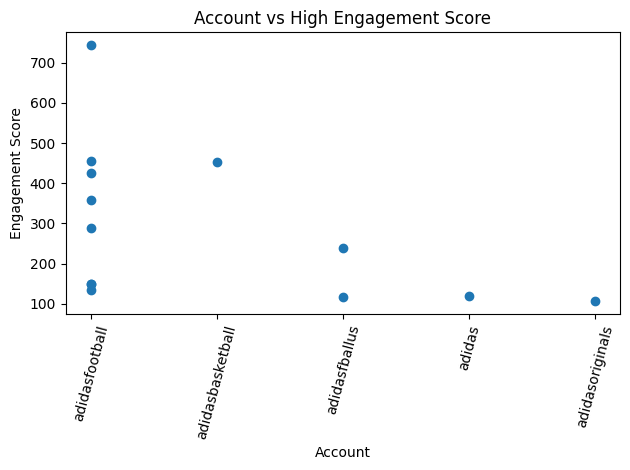

In [140]:
"""
High engagement posts were mainly related to football/soccer content. News, awards, brand deals,
and one documentary release date announcement
5/13 Soccer awards (Ballon D'or) Soccer Tournament Wins (Kopa, MLS Champions, etc.)
4/13 Brand Deals/Announcements (Leo Messi x Bad Bunny), also involve revealing sneaker drops
2/13 - Travis Hunter/College Football (239.74 / 117.27)
1/13 - Shoe documentary announcement (147.8)
1/13 (barely above average engagement 107.13) about fashion week
"""
plt.scatter(high_engagement["Account Username"], high_engagement["Engagement Score"])
plt.xlabel("Account")
plt.ylabel("Engagement Score")
plt.title("Account vs High Engagement Score")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [141]:
"""
Lets undo our relative enagement score for a value that can be quantitatevly compared
in a pie chart

We will do this by multiplying by our avg_engagement_score and dividing by 100 for each engagement score
to gather the raw value

the avg_engagement_score is = 46700

We could have also just added the likes and comments to get this value
"""
raw_engagement_score = tool.insta_df.copy()

raw_engagement_score["Engagement Score"] = raw_engagement_score["Engagement Score"] * 46700 / 100

raw_engagement_score.to_csv("data/instagram/instagram_data_1_raw_engagement.csv", index=False)

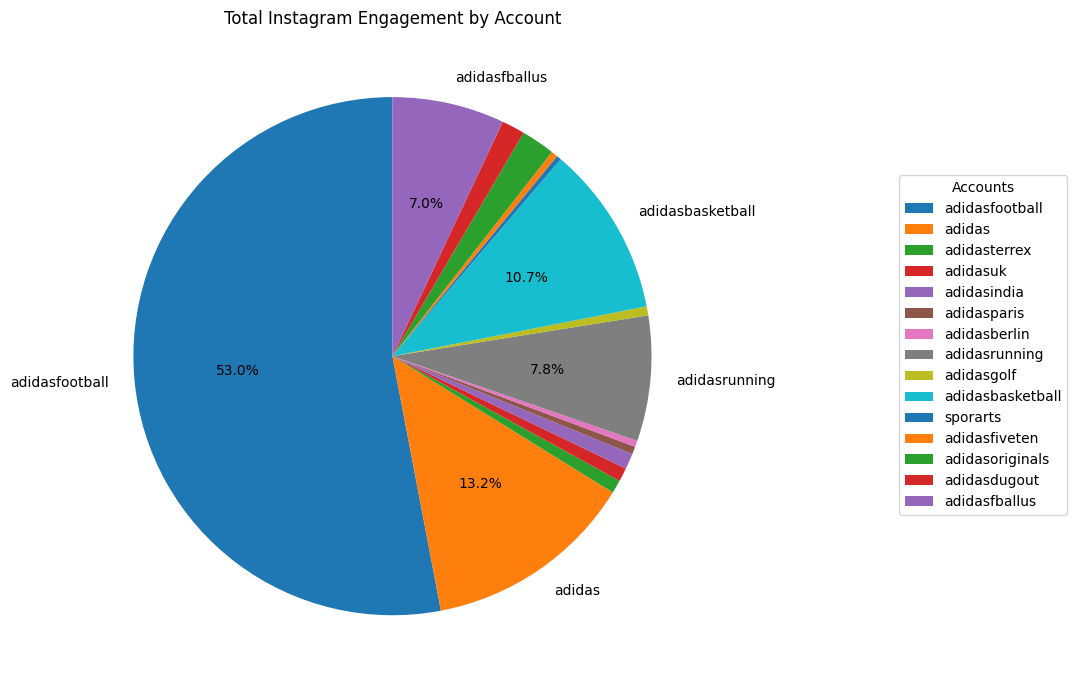

In [161]:
"""
Generate a pie chart to display the engagement each specific account
contributes to adidas audience engagement


"""
data_copy = raw_engagement_score.copy()
accounts = data_copy["Account Username"].unique().tolist() # Get each unique account

cumulative_engagement = []
for account in accounts: # For every account get their total engagement score
    cumulative_engagement.append(data_copy.loc[data_copy["Account Username"] == account, "Engagement Score"].sum())

fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    cumulative_engagement,
    labels=accounts,
    autopct='%1.1f%%', # Generats percentages
    startangle=90)

fig.legend(
    accounts,
    title="Accounts",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5))  # Formatting for the legend, was overlapping chart

ax.set_title("Total Instagram Engagement by Account")

for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    percent = float(autotext.get_text().replace("%", ""))
    if percent < 5:
        text.set_text("") # Remove titles with insignificant titles
        autotext.set_text("") # Remove small percentages

plt.tight_layout()
plt.show()

In [143]:
"""
Making CSV files for each of the top adidas accounts (> 5% of total engagement)
so conclusions can be drawn on why their posts get engagement
"""
# Adidas Football
# Using already created instagram_data_1_adidasfootball.csv

# Main content contained: 8 posts total, ALL high performing (lowest score: 134.59, highest: 744.14)
# 3 posts about Ballon D'or awards (two womens, 1 mens which was best 2024 keeper)
# Kopa american winner post, MLS champion post
# Multiple brand neal/sneaker announcement posts


# Adidas
adidas_rows = tool.insta_df[tool.insta_df["Account Username"] == "adidas"].copy()
adidas_rows.sort_values(by="Date", inplace=True)
adidas_rows.to_csv("data/instagram/adidas.csv", index=False)
# Main content contained: 6/14 about Olympics Gold medalists, high performing post was a sneaker announcement (118.13)

# Adidas Running
adidas_running_rows = tool.insta_df[tool.insta_df["Account Username"] == "adidasrunning"].copy()
adidas_running_rows.sort_values(by="Date", inplace=True)
adidas_running_rows.to_csv("data/instagram/adidas_running.csv", index=False)
# Main content contained: Mainly marathon records, highest performing post was a dedication to a deceased runner (98.36)

# Adidas Basketball
adidas_basketball_rows = tool.insta_df[tool.insta_df["Account Username"] == "adidasbasketball"].copy()
adidas_basketball_rows.sort_values(by="Date", inplace=True)
adidas_basketball_rows.to_csv("data/instagram/adidas_basketball.csv", index=False)
# Main content contained: 2 WNBA posts (low scores ~15), 1 mourning post (56.23), highest post was a sneaker announcement (453.77)

# Adidas Football US
adidas_fballus_rows = tool.insta_df[tool.insta_df["Account Username"] == "adidasfballus"].copy()
adidas_fballus_rows.sort_values(by="Date", inplace=True)
adidas_fballus_rows.to_csv("data/instagram/adidas_fballus.csv", index=False)
# Main content contained: Both Travis Hunter, brand deal and winning heisman, both high performing (239.74, 117.27 respectively)

# Biggest driving factor -> Relevant (related to account content) Headline News (important events)

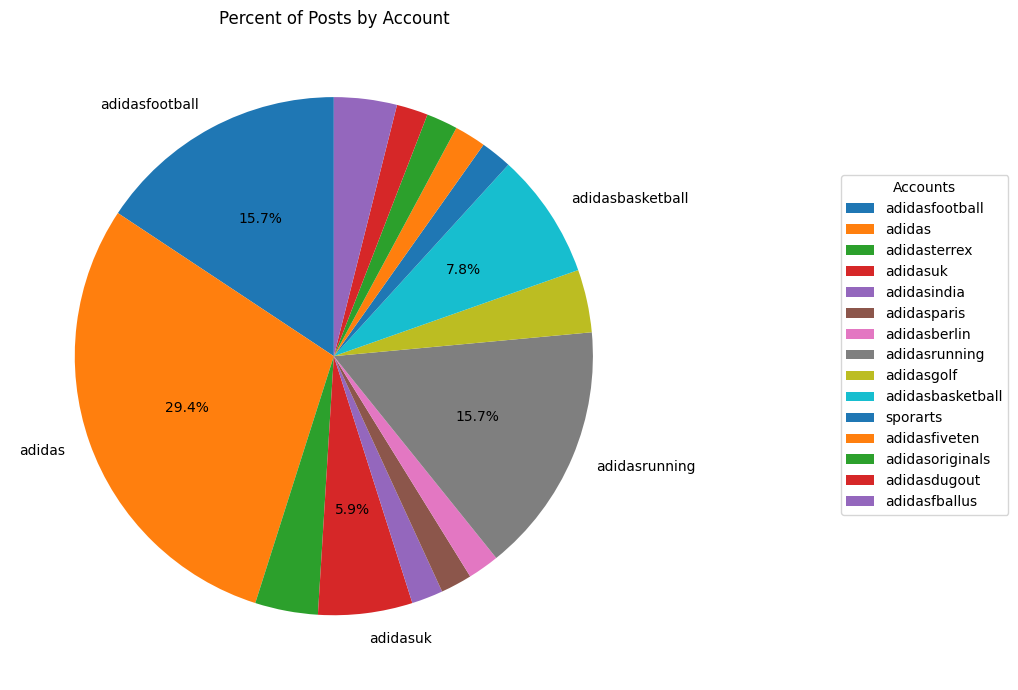

In [144]:
"""
Lets also make a pie chart to show % of total posts per each account,
This lets us understand if adidas user engagement is created through quantity of posts
"""

number_of_posts = []
for account in accounts:
    number_of_posts.append(len(data_copy[data_copy["Account Username"] == account]))

fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    number_of_posts,
    labels=accounts,
    autopct='%1.1f%%', # Generats percentages
    startangle=90)

fig.legend(
    accounts,
    title="Accounts",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5))  # Formatting for the legend, was overlapping chart

ax.set_title("Percent of Posts by Account")

for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    percent = float(autotext.get_text().replace("%", ""))
    if percent < 5:
        text.set_text("") # Remove titles with insignificant titles
        autotext.set_text("") # Remove small percentages

plt.tight_layout()
plt.show()

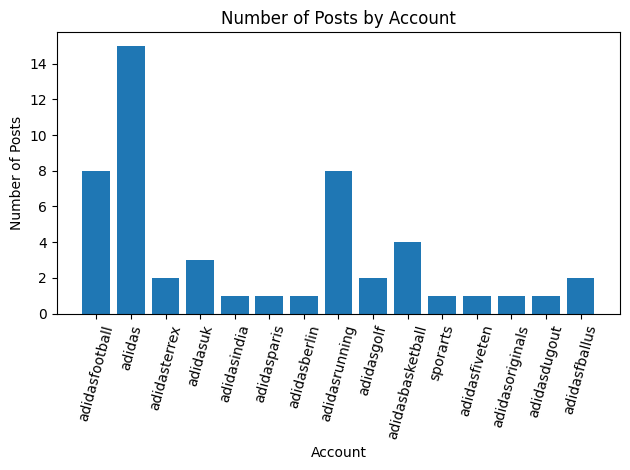

In [145]:
"""
Lets also make a bar chart to display this information
"""
plt.bar(accounts, number_of_posts)
plt.xlabel("Account")
plt.ylabel("Number of Posts")
plt.title("Number of Posts by Account")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [146]:
class EnsembleTiktokDataCollector(EnsembleDataCollector):
    """
    A TikTok data collector, holding methods to be used in parsing raw TikTok JSON files
    """
    def __init__(self, output_csv="data/tiktok/tiktok_data.csv"):
        """
        Initializes EnsembleTikTokDataCollector

        Parameters:
        output_csv (str) - the output csv file path
        """
        
        self.output_csv = output_csv

        self.field_names = [
            "Post ID", "Account Username", "Type of Post", "Date", "Day of Week", "Time of Day",
            "Likes", "Comments", "Caption", "Hashtags", "Play Count", "Follower Count"
        ] # Stores the headers of the metadata we are collecting
        
    
    def process_all_json_in_folder(self, folder_path):
        """
        Process all validated JSON files in the specified folder, extract important metadata, and save to csv

        Parameters:
        folder_path (str) - the specified folder path
        """

        # Open csv to be written to, allows us to write after collecting data from each individual JSON
        with open(self.output_csv, "w", newline="", encoding="utf-8") as output:
            writer = csv.DictWriter(output, self.field_names)
            writer.writeheader()
        
            # Loop through each file in folder
            for file in os.listdir(folder_path):
                if file.endswith(".json"): # Safety check, I don't think this is necessary but just in case
                    file_path = os.path.join(folder_path, file)
                    try:
                        # Try to open and load file JSON
                        with open(file_path, "r", encoding="utf-8") as fp:
                            
                            json_data = json.load(fp)

                            # Updated this logic to account for TikTok JSON structure
                            if "data" in json_data and len(json_data["data"]) > 0: # The JSON is valid and holds information
                                # Get the list of posts
                                posts = json_data["data"]
                                # Iterate through each post, gathering data and writing to output_csv as we go
                                for post in posts: 
                                    post_data = self.collect_metadata(post)
                                    writer.writerow(post_data) # write each post's parsed data to csv
                    except Exception as e:
                        print(f"Error loading JSON for {file_path}: {e}")
                        continue

    def collect_metadata(self, post):
        """
        Collects all relevant tiktok metadata stored in the post. Specifically:
        "Post ID", "Account Username", "Type of Post", "Date", "Day of Week", "Time of Day",
        "Likes", "Comments", "Caption", "Hashtags", "Play Count", "Follower Count"

        Parameters:
        post (Json object) - The JSON data of the respective post

        Returns:
        metadata - a structured row dictionary
        """
        # Convert timestamp to datetime object
        try:
            dt_object = self.timestamp_to_date(post["create_time"])
        except Exception as e:
            print(f"Error parsing timestamp: {e}")
            dt_object = None

        # Collect caption text
        try:
            caption_text = post["desc"]
        except Exception as e:
            print(f"Error parsing caption: {e}")
            caption_text = None
        
        try:
            metadata = {
                "Post ID": post["aweme_id"],
                "Account Username": post["author"]["ins_id"],
                "Type of Post": post["content_type"],
                "Date": dt_object.strftime("%Y-%m-%d") if dt_object else None,
                "Day of Week": dt_object.strftime("%A") if dt_object else None,
                "Time of Day": dt_object.strftime("%H:%M:%S") if dt_object else None,
                "Likes": post["statistics"].get("digg_count", 0),
                "Comments": post["statistics"].get("comment_count", 0),
                "Caption": caption_text,
                "Hashtags": self.get_hashtags_from_caption(caption_text) if caption_text else None,
                "Play Count": post["statistics"].get("play_count", 0),
                "Follower Count": post["author"].get("follower_count", 0)
            }
        except Exception as e:
            print(f"Error parsing metadata: {e}")

        return metadata

    def get_hashtags_from_caption(self, caption_text):
        """
        Returns a string list of hashtags within the given caption text

        Parameters:
        caption_text (str) - The caption text

        Returns:
        hashtags (str) - The string list of hashtags in the caption
        """

        hashtag_list = re.findall(r"#\w+", caption_text)

        if not hashtag_list:
            return "" # No hashtags found

        hashtags = ", ".join(hashtag_list)

        return hashtags
    

In [147]:
# Code used to gather necessary tiktok metadata
tiktok_data_collector = EnsembleTiktokDataCollector()

tiktok_data_collector.process_all_json_in_folder("data/raw_tiktok")

In [148]:
tiktok_df = pd.read_csv("data/tiktok/tiktok_data.csv") # Make the tiktok data into a DataFrame

In [149]:
class TiktokAnalysisTool:
    """
    A class that holds all the methods and tools used to
    gather relevant information from the collected tiktok metadata.
    """
    def __init__(self, tiktok_df=tiktok_df):
        self.tiktok_df = tiktok_df

    def generate_engagement_scores(self):
        """
        Create a new column in insta_df called 'Engagement Score',
        equal to the total likes + comments of a post / follower count.
        Used to determine if a post is above, below, or average in terms of engagement.
        """
        self.tiktok_df["Engagement Score"] = ((self.tiktok_df["Likes"] + self.tiktok_df["Comments"]) / self.tiktok_df["Follower Count"]) * 100


    def generate_viewer_engagement_scores(self):
        """
        Create a new colun in insta_df called "Viewer Engagement Score"
        only if the given post is a video, the score is
        equal to the total likes + comments / plays.
        Used to determine how well the video engaged the viewer.

        Viewer Engagement Score:
        Based on the number of views determines what % of those viewers engaged with the post
        """
        self.tiktok_df["Viewer Engagement Score"] = self.tiktok_df.apply(
            lambda row: round((row["Likes"] + row["Comments"]) / row["Play Count"] * 100, 2),
            axis = 1)
        
    def relative_engagement_score(self, avg_engagement_score):
        """
        Create the 'Relative Engagement Score' Column by relating the current score
        to a relative score based on a given avg_engagement_score
        new Engagement Score:
        > 100 -> above average,
        == 100 -> average,
        < 100 -> below average

        Parameters:
        avg_engagement_score (float): The average engagement score for all tiktok posts
        """
        self.tiktok_df["Relative Engagement Score"] = round((self.tiktok_df["Engagement Score"] / avg_engagement_score * 100), 2)

In [150]:
tool = TiktokAnalysisTool()

# Remove duplicate occurences of posts from data, keeping the most up-to-date version of each post 
# ~20,000 rows -> 88 rows
tool.tiktok_df.drop_duplicates(subset="Post ID", keep="last", inplace=True)

# These scores are not super helpful in the current form.
tool.generate_engagement_scores()

# Generating average engagement score
avg_engagement = tool.tiktok_df["Engagement Score"].sum() / len(tool.tiktok_df)
print(avg_engagement) # returns ~1.112

# Generate relative engagement compared average
tool.relative_engagement_score(avg_engagement)
 
tool.generate_viewer_engagement_scores() # Finding % of viewers that engage for each post

tool.tiktok_df["Date"] = pd.to_datetime(tool.tiktok_df["Date"]) # Convert string back to datetime

tool.tiktok_df.sort_values(by="Date", inplace=True) # Sort by date

tool.tiktok_df.to_csv("data/tiktok/tiktok_data_1.csv", index=False)

1.1126341602976748


In [151]:
"""
Looking through data clear outlier with EXCEPTIONALLY high performance 'zip zip zip alien meme' reference
other pop culture references did no lead to as high of engagement, infact typically it performed well below average/
Also, a second post was made featuring the zip alien meme, and comparing it to the viral one, it underperformed exceptionally.

Going to gather above average engagement scores to guide analysis,
Ordering by engagement then returning high performing posts
"""

engagement_score = tool.tiktok_df.copy()
engagement_score.sort_values(by="Engagement Score", inplace=True, ascending=False)
engagement_score.to_csv("data/tiktok/data_by_engagement.csv", index=False)

high_engagement = engagement_score[engagement_score["Relative Engagement Score"] > 100].copy()
high_engagement.to_csv("data/tiktok/high_engagement.csv", index=False)

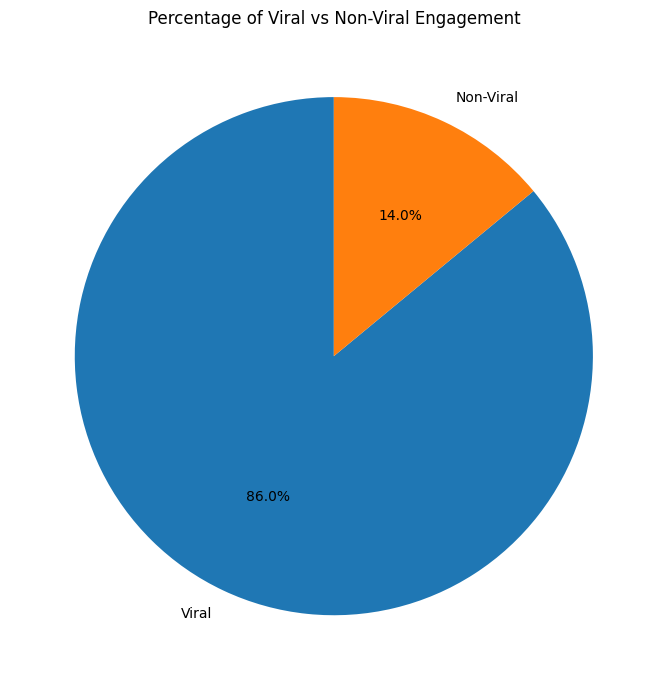

In [152]:

"""
Making a piechart to show % of engagement in 'viral' (relative score > 100) posts 
versus 'nonviral' (relative score < 100).
"""

labels = ["Viral", "Non-Viral"]

# Getting totals for viral vs nonviral engagement
viral_engagement = engagement_score.loc[engagement_score["Relative Engagement Score"] > 100, "Engagement Score"].sum()
nonviral_engagement = engagement_score.loc[engagement_score["Relative Engagement Score"] < 100, "Engagement Score"].sum()

total_engagment = [viral_engagement, nonviral_engagement]

fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    total_engagment,
    labels=labels,
    autopct='%1.1f%%', # Generats percentages
    startangle=90)

ax.set_title("Percentage of Viral vs Non-Viral Engagement")

plt.tight_layout()
plt.show()

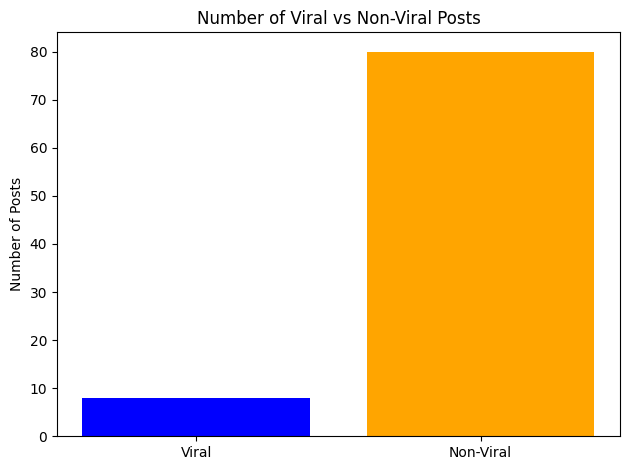

In [164]:
"""
Now lets see how many posts make up Viral vs Non Viral
"""

viral_count = len(high_engagement)
nonviral_count = len(tool.tiktok_df) - viral_count

post_counts = [viral_count, nonviral_count]

colors = ["blue", "orange"]

plt.bar(labels, post_counts, color=colors)
plt.ylabel("Number of Posts")
plt.title("Number of Viral vs Non-Viral Posts")
plt.tight_layout()
plt.show()

In [162]:
"""
There are 8 viral posts to 80 non-viral, yet viral posts represent 86% of all tiktok engagement.

Thus it is very clear a distinct subset of viral posts are skewing the relative score.
Will be storing those to CSV, creating a new CSV without them, and recalculating average engagement score.
Then the relative score will be recomputed (excluding those outliers)
"""

nonviral_tool = TiktokAnalysisTool()

nonviral_tool.tiktok_df = engagement_score[engagement_score["Relative Engagement Score"] < 100].copy()

# Getting new average engagement score
avg_engagement = nonviral_tool.tiktok_df["Engagement Score"].sum() / len(nonviral_tool.tiktok_df)
print(avg_engagement) # ~0.1714

# Generate relative engagement compared average
nonviral_tool.relative_engagement_score(avg_engagement)

nonviral_tool.tiktok_df.to_csv("data/tiktok/tiktok_nonviral_relative_engagement.csv", index=False)

0.1714037444648114


In [118]:
"""
Now that we have a subset of 'nonviral' posts lets acquire the high engagement performing
posts and look into what information/data they hold
"""

nonviral_high_engagement = nonviral_tool.tiktok_df.copy()
nonviral_high_engagement = nonviral_high_engagement[nonviral_high_engagement["Relative Engagement Score"] > 100].copy()
nonviral_high_engagement.to_csv("data/tiktok/nonviral_high_engagement.csv", index=False)


In [212]:
"""
There are 20 nonviral high engagement posts, and as all these posts are from Adidas's main TikTok account
we cannot seperate by account to beter analyze the content.
Thus we will attempt to partion these high engagement posts via their associated Hashtags
"""

# Since all hashtags are stored in string lists, lets make a single string that contains all hashtags of the posts
all_hashtags_as_string = ", ".join(row["Hashtags"] for _, row in nonviral_high_engagement.iterrows() if row["Hashtags"])

all_hashtags_as_list = all_hashtags_as_string.split(", ")

# We will use a set to store each unique Hashtag
hashtags = set(all_hashtags_as_list)

# We now have 53 unique hashtags
print(len(hashtags))

total_nonviral_high_engagement = nonviral_high_engagement["Engagement Score"].sum()

# For each hashtag, if a post has uses the hashtag we add its engagement score to the cumulative amount for that hashtag
# The proportional engagement score shows us what % a subsets engagement utilize a hashtag (Ex. 50% of viral posts engagement had the hashtag #Adidas)
# Have to use a proportion since hashtags can be included in multiple posts
proportional_hashtag_engagement = []
for tag in hashtags:
    posts_with_tag = nonviral_high_engagement[nonviral_high_engagement["Hashtags"].str.contains(tag)]
    proportional_hashtag_engagement.append(posts_with_tag["Engagement Score"].sum() / total_nonviral_high_engagement)

53


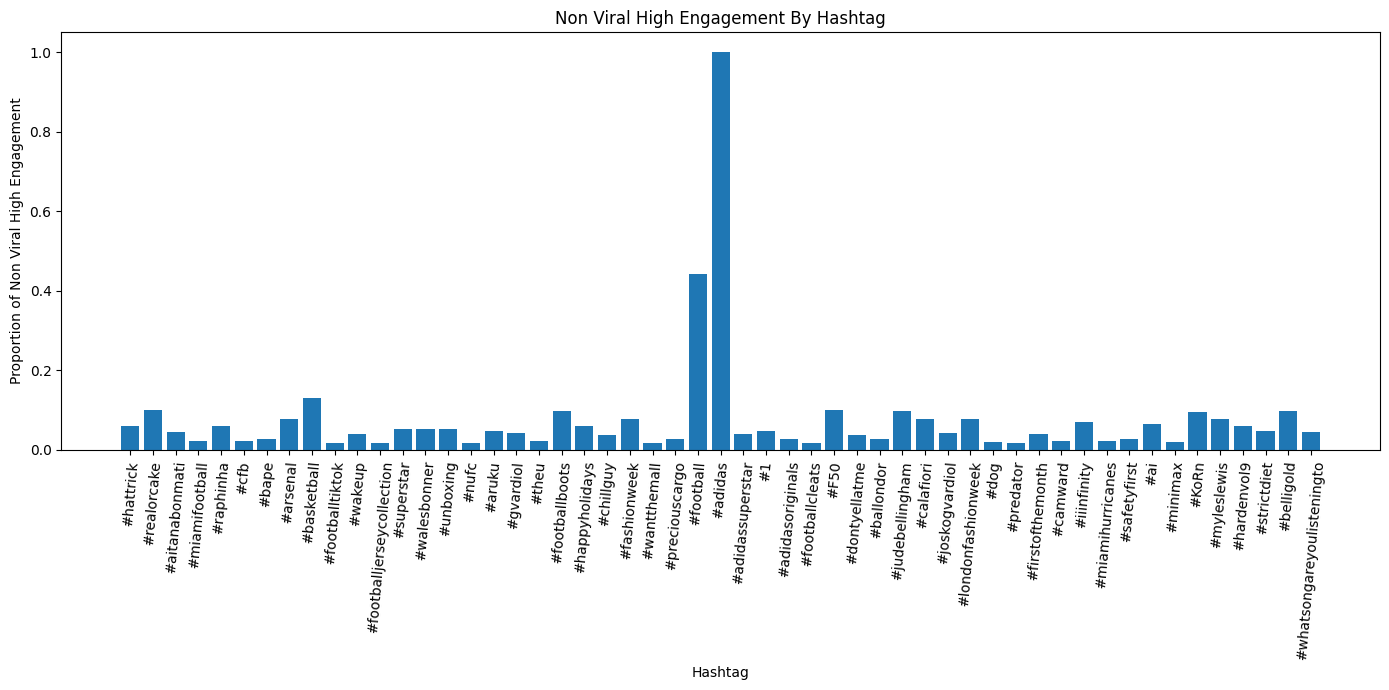

In [217]:
"""
Initial plan: make a pie chart to visualize and conclude results

Revised plan: Use a bar chart to display proportion of engagement via hashtag
"""

fig, ax = plt.subplots(figsize=(14, 7))


ax.bar(list(hashtags), proportional_hashtag_engagement, label=hashtags)
plt.xlabel("Hashtag")
plt.ylabel("Proportion of Non Viral High Engagement")
plt.title("Non Viral High Engagement By Hashtag")
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()

21


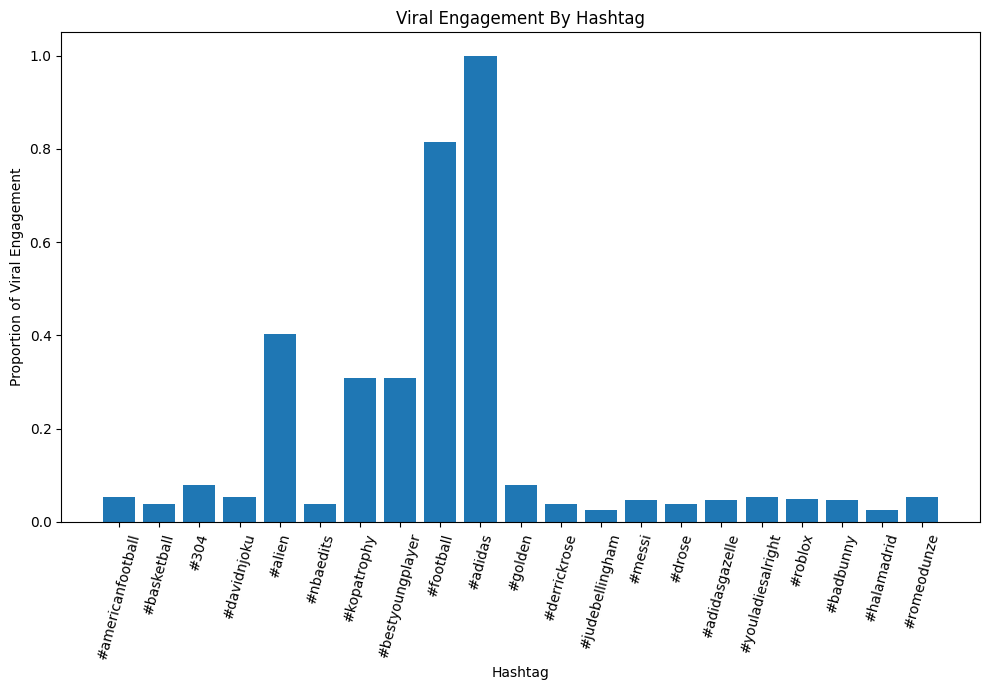

In [211]:
"""
Let us repeat this process for the 'viral' posts to see what topics drove user interaction

Tiktok does confirm that adidas audience engagement is heavily driven by sport news announcements and recaps as seen through the 
80% of total viral engagement score being related to football, while also having 11% in the high engagement non viral posts.
However while the conclusions drawn from the Instagram data remain true in TikTok a new factor is most certainly present that was not as existent in
Instagram.

Pop-culture and memes played a significantly higher role in TikTok user engagement, most well reflected by the highest engaged post which was Adidas's own
take on a viral meme #alien (also #roblox was included, very much a popculture hashtag/genz).

The impact of pop culuture for user engagement was also seen in the non-viral high engagement posts as well through the hashtags #chillguy, #londonfashionweek,
and #realorcake to name a few.

With this in mind it is still important to emphasize that the VAST majority of posts that directly correlated to user engagement related to
football news, and  general sports/footware announcements
"""


# Since all hashtags are stored in string lists, lets make a single string that contains all hashtags of the posts
all_hashtags_as_string = ", ".join(row["Hashtags"] for _, row in high_engagement.iterrows() if row["Hashtags"])

all_hashtags_as_list = all_hashtags_as_string.split(", ")

# We will use a set to store each unique Hashtag
hashtags = set(all_hashtags_as_list)

# We now have 21 unique hashtags
print(len(hashtags))

# Gather the total engagement in the subset to make accurate proportions
total_viral_engagement = high_engagement["Engagement Score"].sum()

# For each hashtag, if a post has uses the hashtag we add the proportional engagement score to the cumulative amount for that hashtag
# The proportional engagement score shows us what % a subsets engagement utilize a hashtag (Ex. 50% of viral posts engagement had the hashtag #Adidas)
# Have to use a proportion since hashtags can be included in multiple posts
proportional_hashtag_engagement = []
for tag in hashtags:
    posts_with_tag = high_engagement[high_engagement["Hashtags"].str.contains(tag)]
    proportional_hashtag_engagement.append(posts_with_tag["Engagement Score"].sum() / total_viral_engagement)

fig, ax = plt.subplots(figsize=(10, 7))


ax.bar(list(hashtags), proportional_hashtag_engagement, label=hashtags)
plt.xlabel("Hashtag")
plt.ylabel("Proportion of Viral Engagement")
plt.title("Viral Engagement By Hashtag")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

177


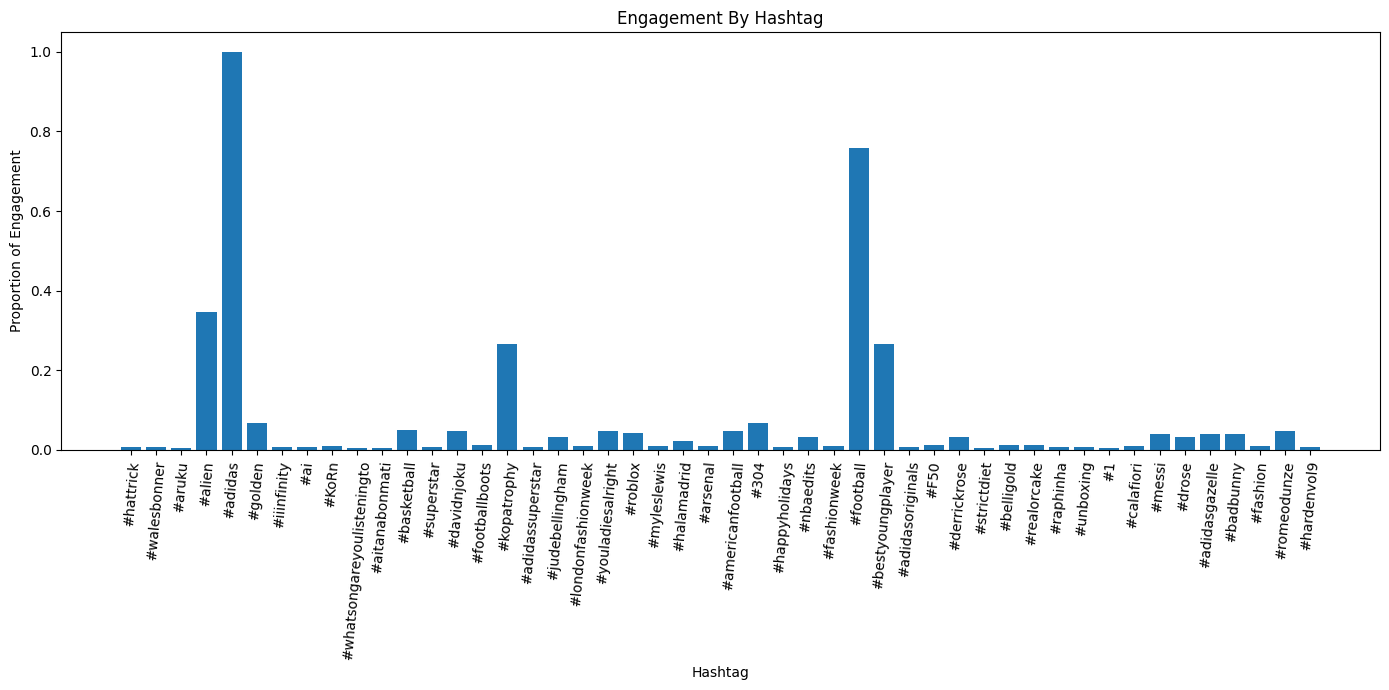

In [236]:
"""
Lets make a bar chart to show the baseline for adidas engagement across ALL score levels,
To make the set manageable we will filter out proportional engagement < 0.01
"""

tiktok_data = tool.tiktok_df.copy()

# Gather all hashtags
# Make sure to account for posts without hashtags

tiktok_data["Hashtags"] = tiktok_data["Hashtags"].fillna("No Hashtags")

all_hashtags_as_string = ", ".join(row["Hashtags"] for _, row in tiktok_data.iterrows() if row["Hashtags"])

all_hashtags_as_list = all_hashtags_as_string.split(", ")

# We will use a set to store each unique Hashtag
hashtags = set(all_hashtags_as_list)

# We now have 53 unique hashtags
print(len(hashtags))

total_engagement = engagement_score["Engagement Score"].sum()

# For each hashtag, if a post has uses the hashtag we add its engagement score to the cumulative amount for that hashtag
# The proportional engagement score shows us what % a subsets engagement utilize a hashtag (Ex. 50% of viral posts engagement had the hashtag #Adidas)
# Have to use a proportion since hashtags can be included in multiple posts
proportional_hashtag_engagement = []
for tag in hashtags:
    posts_with_tag = tiktok_data[tiktok_data["Hashtags"].str.contains(tag)]
    proportional_hashtag_engagement.append(posts_with_tag["Engagement Score"].sum() / total_engagement)

hashtag_list = list(hashtags)

filtered_hashtags = []
filtered_proportional_hashtag_engagement = []

# Filter out posts with less than 0.005 proportion engagement
for i, (tag, engagement) in enumerate(zip(hashtag_list, proportional_hashtag_engagement)):
    if engagement >= 0.005:
        filtered_hashtags.append(tag)
        filtered_proportional_hashtag_engagement.append(engagement)

"""
Now we display proportional engagement based on hashtag for all filtered posts

The results highlight the findings found in analyzing previous high engagement posts.
"""

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(filtered_hashtags, filtered_proportional_hashtag_engagement, label=filtered_hashtags)
plt.xlabel("Hashtag")
plt.ylabel("Proportion of Engagement")
plt.title("Engagement By Hashtag")
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()